## Simple linear Model in Pytorch 


Code Richard transformed in pytorch

March 19, 2020

$$y_i = ax_i + N(0,1) \qquad a \sim N(0, 100)$$

The posterior is
$$a \sim N\left( \frac{\sum x_i y_i}{\frac{1}{100}+ \sum x_i^2}, (\frac{1}{100} +\sum x_i^2)^{-1}\right)$$



We will use  Gaussian  distributions as the variational family 
$$q_\phi(a) = N(\mu, \sigma^2)$$


In [1]:
import scipy as sp
import numpy as np
import matplotlib as plt
from torch.autograd import Variable
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.distributions import *
from torch import optim as optim
import pylab as plt

In [2]:
from scipy.stats import norm
n = 100
m = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
x = m.sample(sample_shape=torch.Size([n])) 
norm = m.sample(sample_shape=torch.Size([n])) 
y = torch.mul(x, torch.Tensor([2])) +norm

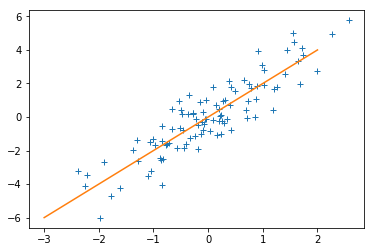

In [3]:
plt.plot(x,y, '+');
ts = np.linspace(-3,2,100)
xs = 2*ts 
plt.plot(ts,xs);

In [4]:
mu_posterior=torch.sum(torch.mul(x,y))/(1./100+torch.sum(torch.pow(x,2)))
sigma2_posterior = 1./(1./100+torch.sum(torch.pow(x,2)))
mu_posterior

tensor(1.9750)

In [5]:
sigma2_posterior

tensor(0.0099)

## Variational Inference

In [6]:
def KL(mu, sigma2):
    return(-0.5* torch.log(sigma2)+(sigma2+torch.pow(mu, 2)/200.))

def Eloglike(mu, sigma2): 
    return(-0.5*torch.sum(torch.pow(y-torch.mul(mu,x),2))-0.5*sigma2*torch.sum(torch.pow(x,2)))

def elbo(mu, logvar):
    sigma2=torch.exp(logvar)
    ELBO = Eloglike(mu, sigma2)-KL(mu, sigma2)
    return(ELBO)

def loss(mu, logvar):
    return (-1* elbo(mu, logvar))

In [7]:
def KL(mu, sigma2):
    return(-0.5* torch.log(sigma2)+(sigma2+torch.pow(mu, 2)/200.))

def Eloglike(mu, sigma2): 
    return(-0.5*torch.sum(torch.pow(y-torch.mul(mu,x),2))-0.5*sigma2*torch.sum(torch.pow(x,2)))

def elbo(mu, logvar):
    sigma2=torch.exp(logvar)
    ELBO = Eloglike(mu, sigma2)-KL(mu, sigma2)
    return(ELBO)

def loss(mu, logvar):
    return (-1* elbo(mu, logvar))


In [17]:
mu = torch.nn.Parameter(torch.Tensor([1.0]),requires_grad=True)
logvar = torch.nn.Parameter(torch.log(torch.Tensor([2])),requires_grad=True)
elbo(mu, logvar)

tensor([-200.5616], grad_fn=<SubBackward0>)

In [18]:
class VI(nn.Module):
    def __init__(self):
        super().__init__()
        self.qmu = torch.nn.Parameter(torch.Tensor([1.0]), requires_grad=True)
        self.qlogvar = torch.nn.Parameter(torch.log(torch.Tensor([2])), requires_grad=True)

    def KL(mu, sigma2):
        return(-0.5* torch.log(sigma2)+(sigma2+torch.pow(mu, 2)/200.))

    def Eloglike(mu, sigma2): 
        return(-0.5*torch.sum(torch.pow(y-torch.mul(mu,x),2))-0.5*sigma2*torch.sum(torch.pow(x,2)))

    def elbo(mu, logvar):
        sigma2=torch.exp(logvar)
        ELBO = Eloglike(mu, sigma2)-KL(mu, sigma2)
        return(ELBO)

    def forward(self, x, y):
        mu = self.qmu
        logvar = self.qlogvar
        loss = -1* elbo(mu, logvar)
        return loss
    
    
    

https://ruder.io/optimizing-gradient-descent/index.html

#### Stochastic Gradient Descent - SGD

http://www.cs.toronto.edu/~hinton/absps/momentum.pdf

In [93]:
vi = VI()
optim = torch.optim.SGD(vi.parameters(), lr=0.01)

for epoch in range(200):
    optim.zero_grad()
    loss = vi(x,y)
    loss.backward(retain_graph=True)
    optim.step()

In [92]:
print('True values', mu_posterior, sigma2_posterior)
print('Optimized values=',vi.qmu, torch.exp(vi.qlogvar))

True values tensor(1.9750) tensor(0.0099)
Optimized values= Parameter containing:
tensor([1.9750], requires_grad=True) tensor([0.0240], grad_fn=<ExpBackward>)


#### AdaGrad 

http://jmlr.org/papers/v12/duchi11a.html

In [80]:
vi = VI()
optim = torch.optim.Adagrad(vi.parameters(), lr=0.06)

for epoch in range(1000):
    optim.zero_grad()
    loss = vi(x,y)
    loss.backward(retain_graph=True)
    optim.step()

In [81]:
print('True values', mu_posterior, sigma2_posterior)
print('Optimized values=',vi.qmu, torch.exp(vi.qlogvar))

True values tensor(1.9750) tensor(0.0099)
Optimized values= Parameter containing:
tensor([1.9750], requires_grad=True) tensor([0.2078], grad_fn=<ExpBackward>)


#### Adaptive Moment Estimation - ADAM

https://arxiv.org/abs/1412.6980

In [31]:
vi = VI()
optim = torch.optim.Adam(vi.parameters(), lr=0.005)

for epoch in range(700):
    optim.zero_grad()
    loss = vi(x,y)
    loss.backward(retain_graph=True)
    optim.step()

In [32]:
print('True values', mu_posterior, sigma2_posterior)
print('Optimized values=',vi.qmu, torch.exp(vi.qlogvar))

True values tensor(1.9750) tensor(0.0099)
Optimized values= Parameter containing:
tensor([1.9750], requires_grad=True) tensor([0.2667], grad_fn=<ExpBackward>)


#### AdaDelta 

https://arxiv.org/abs/1212.5701

In [50]:
vi = VI()
optim = torch.optim.Adadelta(vi.parameters(), lr=0.05)

for epoch in range(700):
    optim.zero_grad()
    loss = vi(x,y)
    loss.backward(retain_graph=True)
    optim.step()

In [51]:
print('True values', mu_posterior, sigma2_posterior)
print('Optimized values=',vi.qmu, torch.exp(vi.qlogvar))

True values tensor(1.9750) tensor(0.0099)
Optimized values= Parameter containing:
tensor([1.2167], requires_grad=True) tensor([1.6077], grad_fn=<ExpBackward>)


SGD seems to be the best, less iterations,more accurate...

## VAE

In [176]:
class VAE(nn.Module):
    def __init__(self, x, y):
        '''p : number of parameters in the ODE solver, int (for now)
   
        '''
        super(VAE,self).__init__()
        self.x=x
        self.y=y
        self.qmu = torch.nn.Parameter(torch.Tensor([1.0]), requires_grad=True)
        self.qlogvar = torch.nn.Parameter(torch.log(torch.Tensor([2])), requires_grad=True)
    
        
    def encoder(self, V):
        '''Encoder using a gaussian distribution with parameters mu and logvar'''
        mu = self.qmu
        logvar = self.qlogvar
        return mu, logvar
        
    def reparam(self, mu, logvar):
        '''Reparametrization trick'''
        std = torch.exp(0.5*logvar) 
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def decoder(self, a):
        '''Decoder '''
        return (self.x*a)
    
    def Eloglike(self, a): 
        return(-0.5*torch.sum(torch.pow((self.y-self.decoder(a)),2)))

    def KL(self,mu, logvar):
        return (-0.5* logvar+(torch.exp(logvar)+torch.pow(mu, 2))/200.)
    
    
    def elbo(self, a, mu, logvar):
        elbo = self.Eloglike(a)-self.KL(mu, logvar)
        return(elbo)


    def forward(self):
        mu, logvar = self.encoder(self.x)
        a = self.reparam(mu, logvar)
        loss = -self.elbo(a, mu, logvar)
        print(loss)
 
        return loss

In [177]:
model = VAE(x,y)

In [178]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

n_iter = 10
for i in range(n_iter):
    loss = model()
  
    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
  
    


tensor([156.4964], grad_fn=<NegBackward>)
tensor([9072.2021], grad_fn=<NegBackward>)
tensor([7.4122e+09], grad_fn=<NegBackward>)
tensor([7.5443e+11], grad_fn=<NegBackward>)
tensor([6.2128e+13], grad_fn=<NegBackward>)
tensor([5.1187e+15], grad_fn=<NegBackward>)
tensor([4.2173e+17], grad_fn=<NegBackward>)
tensor([3.4746e+19], grad_fn=<NegBackward>)
tensor([2.8628e+21], grad_fn=<NegBackward>)
tensor([2.3586e+23], grad_fn=<NegBackward>)


In [179]:
model.qmu
model.qlogvar

Parameter containing:
tensor([-7.4862e+08], requires_grad=True)